In [1]:
import sys
import numpy as np
import cv2
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D,MaxPooling2D, Activation, Dropout, BatchNormalization, Input
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import itertools

In [2]:
path = "C:\\DataScience\\ADC\\gray_clothdata2\\"
train_data_path = path+"train"
test_data_path = path+"test"
valid_data_path = path+"valid"

In [3]:
############################################
# Set image size and batch size

img_rows = 224
img_cols = 224
batch_size = 10

In [4]:
############################################
# Set Data Generator for training, testing and validataion.
# Note for testing, set shuffle = false (For proper Confusion matrix)

train_datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical', shuffle=True)

valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow_from_directory(valid_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical', shuffle=True)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical', shuffle=False)


Found 1832 images belonging to 57 classes.
Found 398 images belonging to 57 classes.
Found 452 images belonging to 57 classes.


In [5]:
#########################################################################
# Function for plots images with labels within jupyter notebook


def plots(ims, figsize=(12,12), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1


    for i in range(len(ims)):
        sp = f.add_subplot(cols, rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


{'Addidas': 0, 'Amoco': 1, 'Batman': 2, 'Beretta': 3, "Birki's": 4, 'Birmingham': 5, 'Brioni': 6, 'Brother': 7, 'Buffalo': 8, 'Burberry': 9, 'CCM': 10, 'Ceceba': 11, "Copeland's": 12, 'Desigual': 13, 'Diesel': 14, 'Element': 15, 'Errea': 16, 'Escada': 17, 'Everlast': 18, 'Fox': 19, 'Gap': 20, 'Getty': 21, 'Givova': 22, 'Golite': 23, 'Hanes': 24, 'Hilleberg': 25, 'Hunor': 26, 'ITS': 27, 'LangSha': 28, 'Liberty': 29, 'Los Angeles': 30, 'MONDI': 31, 'Michigan': 32, 'Mizuno': 33, 'Montrail': 34, 'Mountain Equipment': 35, 'Neiman Marcus': 36, 'Nine West': 37, 'Oki': 38, 'Pillsbury': 39, "Poppin'": 40, 'Pye': 41, 'Reebok': 42, 'Salewa': 43, 'Saucony': 44, 'Shaw': 45, 'Sloggi': 46, 'Star Wars': 47, 'Supra': 48, 'Tatonka': 49, 'Trespass': 50, 'Vans': 51, 'White Castle': 52, 'XXX': 53, 'Zoggs': 54, 'lacoste': 55, 'logo Andrew Christian': 56}


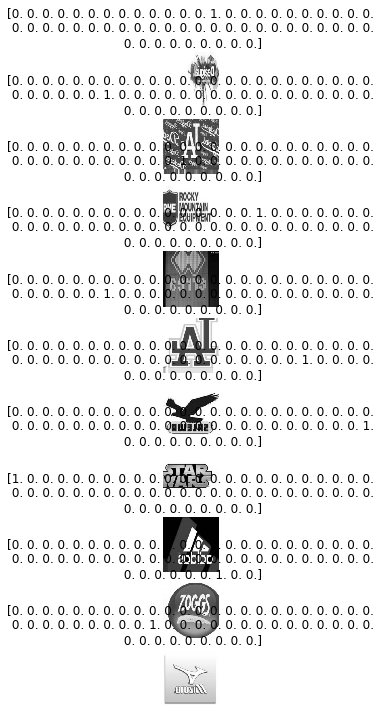

In [6]:
#########################################################################
#Check the training set (with batch of 10 as defined above

imgs, labels = next(train_generator)
num_classes = 57
#Images are shown in the output
plots(imgs, titles=labels)

#Images Classes with index
print(train_generator.class_indices)


#Model Creation / Sequential
model = Sequential([Conv2D(16, (3, 3), padding ='same',activation='relu', 
                           input_shape=(img_rows, img_cols, 3)),
                    MaxPooling2D(),
                    Conv2D(32, (3, 3), padding ='same',activation='relu',
                           input_shape=(img_rows, img_cols, 3)),
                    MaxPooling2D(),    
                    Conv2D(64, (3, 3), padding ='same',activation='relu', 
                           input_shape=(img_rows, img_cols, 3)),
                    MaxPooling2D(),  
                    Conv2D(128, (3, 3), padding ='same',activation='relu', 
                           input_shape=(img_rows, img_cols, 3)),
                    MaxPooling2D(),  
                    Flatten(),            
                    Dense(57, activation='softmax')
                   ])




In [7]:
#Get summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [8]:
#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
#Train the model
history = model.fit_generator(train_generator, steps_per_epoch=20, validation_data=valid_generator, 
                              validation_steps=4, epochs=200)


C:\Users\Admin\Anaconda3\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
20/20 [==============================] - 18s 303ms/step - loss: 93.1185 - accuracy: 0.0114 - val_loss: 3.8963 - val_accuracy: 0.1250
Epoch 2/200
20/20 [==============================] - 5s 263ms/step - loss: 3.8780 - accuracy: 0.0947 - val_loss: 3.5951 - val_accuracy: 0.1250
Epoch 3/200
20/20 [==============================] - 5s 265ms/step - loss: 3.6973 - accuracy: 0.1019 - val_loss: 3.8016 - val_accuracy: 0.2250
Epoch 4/200
20/20 [==============================] - 5s 271ms/step - loss: 3.6240 - accuracy: 0.1699 - val_loss: 3.7864 - val_accuracy: 0.1250
Epoch 5/200
20/20 [==============================] - 6s 287ms/step - loss: 3.5290 - accuracy: 0.1548 - val_loss: 3.2427 - val_accuracy: 0.3250
Epoch 6/200
20/20 [==============================] - 6s 291ms/step - loss: 3.3439 - accuracy: 0.2219 - val_loss: 3.3830 - val_accuracy: 0.3750
Epoch 7/200
20/20 [==============================] - 7s 333ms/step - loss: 3.1285 - accuracy: 0.2787 - val_loss: 3.3976 - val_accuracy: 0.27

Epoch 58/200
20/20 [==============================] - 6s 303ms/step - loss: 1.0583 - accuracy: 0.7063 - val_loss: 1.3076 - val_accuracy: 0.7250
Epoch 59/200
20/20 [==============================] - 6s 302ms/step - loss: 1.0593 - accuracy: 0.7555 - val_loss: 2.3384 - val_accuracy: 0.5000
Epoch 60/200
20/20 [==============================] - 6s 306ms/step - loss: 1.0452 - accuracy: 0.7597 - val_loss: 1.6033 - val_accuracy: 0.6750
Epoch 61/200
20/20 [==============================] - 6s 305ms/step - loss: 1.1855 - accuracy: 0.7320 - val_loss: 1.8166 - val_accuracy: 0.6250
Epoch 62/200
20/20 [==============================] - 6s 304ms/step - loss: 1.1985 - accuracy: 0.7100 - val_loss: 2.1458 - val_accuracy: 0.7250
Epoch 63/200
20/20 [==============================] - 6s 304ms/step - loss: 1.0483 - accuracy: 0.7807 - val_loss: 1.4333 - val_accuracy: 0.6250
Epoch 64/200
20/20 [==============================] - 6s 303ms/step - loss: 1.1772 - accuracy: 0.7036 - val_loss: 1.6135 - val_accuracy:

Epoch 115/200
20/20 [==============================] - 6s 302ms/step - loss: 0.6716 - accuracy: 0.8323 - val_loss: 1.8644 - val_accuracy: 0.7500
Epoch 116/200
20/20 [==============================] - 6s 296ms/step - loss: 0.4997 - accuracy: 0.8594 - val_loss: 2.2788 - val_accuracy: 0.7000
Epoch 117/200
20/20 [==============================] - 6s 308ms/step - loss: 0.6618 - accuracy: 0.8093 - val_loss: 1.9804 - val_accuracy: 0.6500
Epoch 118/200
20/20 [==============================] - 6s 302ms/step - loss: 0.5983 - accuracy: 0.8595 - val_loss: 1.0146 - val_accuracy: 0.7750
Epoch 119/200
20/20 [==============================] - 6s 297ms/step - loss: 0.6885 - accuracy: 0.8209 - val_loss: 1.8490 - val_accuracy: 0.6750
Epoch 120/200
20/20 [==============================] - 6s 296ms/step - loss: 0.5229 - accuracy: 0.8669 - val_loss: 1.7517 - val_accuracy: 0.7250
Epoch 121/200
20/20 [==============================] - 6s 301ms/step - loss: 0.6791 - accuracy: 0.8299 - val_loss: 1.8200 - val_ac

In [10]:
#Get the accuracy score

test_score = model.evaluate_generator(test_generator, batch_size)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

C:\Users\Admin\Anaconda3\lib\site-packages\keras\engine\training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 77.00%
[INFO] Loss:  1.490146279335022


Text(0.5, 1.0, 'Accuracy Curves')

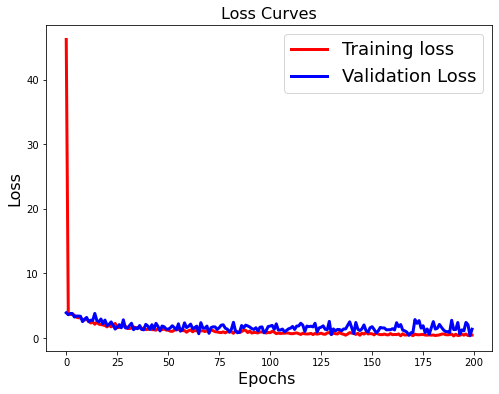

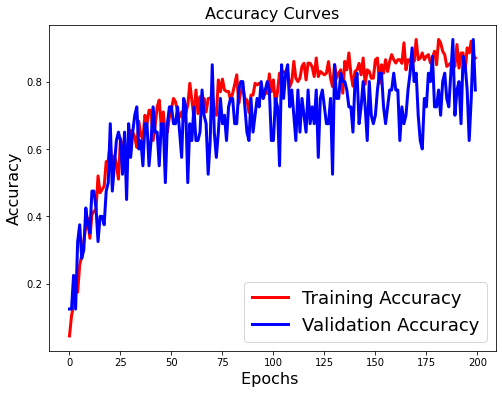

In [16]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)



# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


In [17]:
##################################################################################################
#Plot the confusion matrix. Set Normalize = True/False


def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(90,90))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xticks(fontsize=45)
    plt.yticks(fontsize=45)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [18]:
#Print the Target names
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
print(target_names)

['Addidas', 'Amoco', 'Batman', 'Beretta', "Birki's", 'Birmingham', 'Brioni', 'Brother', 'Buffalo', 'Burberry', 'CCM', 'Ceceba', "Copeland's", 'Desigual', 'Diesel', 'Element', 'Errea', 'Escada', 'Everlast', 'Fox', 'Gap', 'Getty', 'Givova', 'Golite', 'Hanes', 'Hilleberg', 'Hunor', 'ITS', 'LangSha', 'Liberty', 'Los Angeles', 'MONDI', 'Michigan', 'Mizuno', 'Montrail', 'Mountain Equipment', 'Neiman Marcus', 'Nine West', 'Oki', 'Pillsbury', "Poppin'", 'Pye', 'Reebok', 'Salewa', 'Saucony', 'Shaw', 'Sloggi', 'Star Wars', 'Supra', 'Tatonka', 'Trespass', 'Vans', 'White Castle', 'XXX', 'Zoggs', 'lacoste', 'logo Andrew Christian']


C:\Users\Admin\Anaconda3\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix


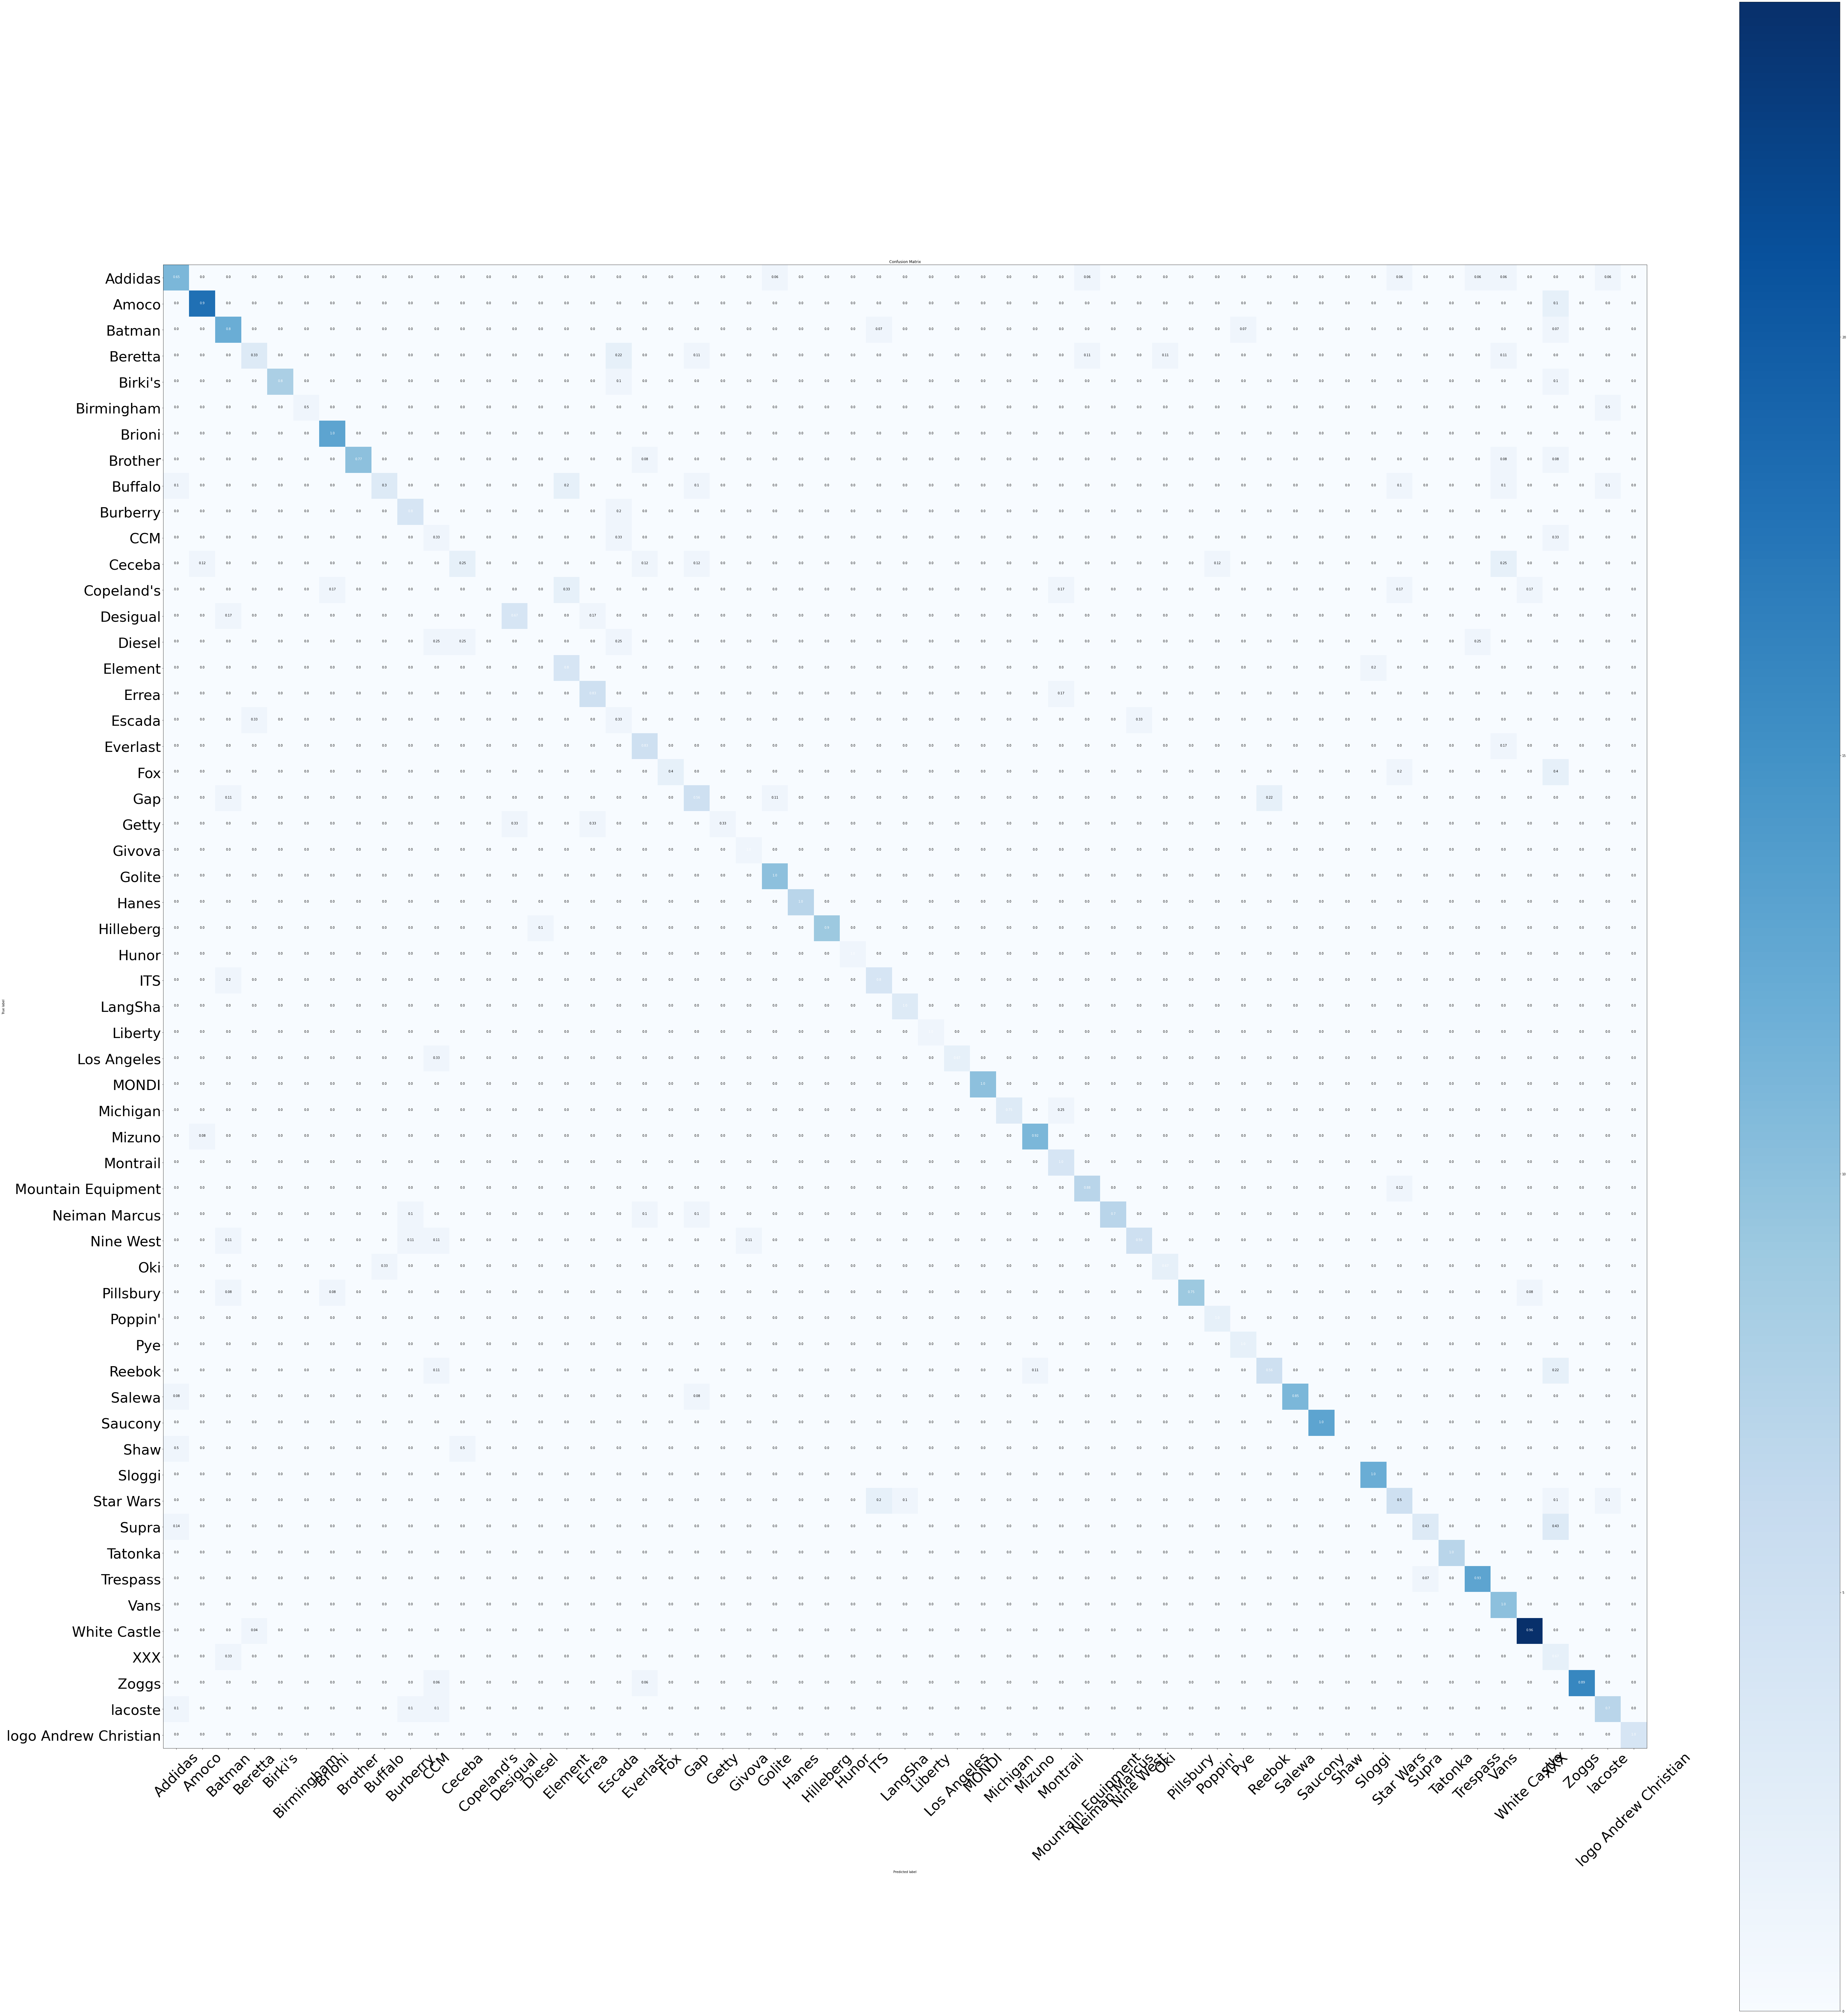

In [19]:
#Confution Matrix 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [15]:
#Print Classification Report

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                       precision    recall  f1-score   support

              Addidas       0.69      0.65      0.67        17
                Amoco       0.90      0.90      0.90        20
               Batman       0.67      0.80      0.73        15
              Beretta       0.60      0.33      0.43         9
              Birki's       1.00      0.80      0.89        10
           Birmingham       1.00      0.50      0.67         2
               Brioni       0.87      1.00      0.93        13
              Brother       1.00      0.77      0.87        13
              Buffalo       0.75      0.30      0.43        10
             Burberry       0.57      0.80      0.67         5
                  CCM       0.14      0.33      0.20         3
               Ceceba       0.50      0.25      0.33         8
           Copeland's       0.00      0.00      0.00         6
             Desigual       0.80      0.67      0.73         6
               Diesel       0.00

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
